# Análisis: Abstract data set for Credit card fraud detection

In [1]:
import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd
import seaborn as sns
#import sklearn as sl
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

## Carga de dataset y resumen de datos

Se usará un dataset~\citep{Joshi_2018} el cual correspende al dataframe que se usará durante el análisis.

In [2]:
df = pd.read_csv("./ds/creditcardcsvpresent.csv")

Este dataframe contiene once columnas. Las primeras dos de ellas serán borradas porque una corresponde a un índice de datos y la otra es una columna completamente vacía, por lo tante irrecuperable.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Merchant_id                     3075 non-null   int64  
 1   Transaction date                0 non-null      float64
 2   Average Amount/transaction/day  3075 non-null   float64
 3   Transaction_amount              3075 non-null   float64
 4   Is declined                     3075 non-null   object 
 5   Total Number of declines/day    3075 non-null   int64  
 6   isForeignTransaction            3075 non-null   object 
 7   isHighRiskCountry               3075 non-null   object 
 8   Daily_chargeback_avg_amt        3075 non-null   int64  
 9   6_month_avg_chbk_amt            3075 non-null   float64
 10  6-month_chbk_freq               3075 non-null   int64  
 11  isFradulent                     3075 non-null   object 
dtypes: float64(4), int64(4), object(4)

### Eliminación de columnas

Primero será necesario guardar la columna objetivo `isFraudulent` en una nueva variable, pues será borrada del dataframe de trabajo debido a que utilizaremos métodos de análisis no supervisados.

In [4]:
ideal_results = df["isFradulent"]

Ahora es posible borrar todas las columnas que no son necesarias para el análisis a realizar.

In [5]:
df = df.drop(["Merchant_id", "Transaction date", "isFradulent"], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Average Amount/transaction/day  3075 non-null   float64
 1   Transaction_amount              3075 non-null   float64
 2   Is declined                     3075 non-null   object 
 3   Total Number of declines/day    3075 non-null   int64  
 4   isForeignTransaction            3075 non-null   object 
 5   isHighRiskCountry               3075 non-null   object 
 6   Daily_chargeback_avg_amt        3075 non-null   int64  
 7   6_month_avg_chbk_amt            3075 non-null   float64
 8   6-month_chbk_freq               3075 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 216.3+ KB


Este dataframe contiene nueve columnas, las cuales no son descritas en la fuente original, por lo que solo es posible intuir su significado, por supuesto, esto podría condicionar la discusión producto del análisis. Es importante hacer enfásis en proporcionar metadatos sobre cualquier conjunto de datos computables: texto, audio, video, dataset, etc.

Seis de esas columnas son de tipo númerico y las tres restantes son categóricas, enseguida se muestra su descripción general.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Average Amount/transaction/day,3075.0,515.026556,291.906978,4.011527,269.788047,502.549575,765.272803,2000.0
Transaction_amount,3075.0,9876.399210,10135.331016,0.000000,2408.781147,6698.891856,14422.568935,108000.0
Total Number of declines/day,3075.0,0.957398,2.192391,0.000000,0.000000,0.000000,0.000000,20.0
Daily_chargeback_avg_amt,3075.0,55.737561,206.634779,0.000000,0.000000,0.000000,0.000000,998.0
6_month_avg_chbk_amt,3075.0,40.022407,155.968840,0.000000,0.000000,0.000000,0.000000,998.0
6-month_chbk_freq,3075.0,0.391870,1.548479,0.000000,0.000000,0.000000,0.000000,9.0


In [8]:
df.describe(include='object').transpose()

,count,unique,top,freq
Is declined,3075,2,N,3018
isForeignTransaction,3075,2,N,2369
isHighRiskCountry,3075,2,N,2870


In [9]:
for o in ["Is declined", "isForeignTransaction","isHighRiskCountry"]:
    print("-----")
    print(df[o].value_counts())

-----
N    3018
Y      57
Name: Is declined, dtype: int64
-----
N    2369
Y     706
Name: isForeignTransaction, dtype: int64
-----
N    2870
Y     205
Name: isHighRiskCountry, dtype: int64


### Tratamiento de variables categóricas

Se crean variables  separadas, para no usar  variables categóricas. La variable  categórica `Is declined` que toma  valores `Y`  o `N`  en `df["Is declined"]`  se puede  sustituir por  dos variables  dummy, booleanas, que son `Is declined_Y` e `Is declined_N`. Es posible tomar ambas variables o solo una de ellas, tal y como se hará en este análisis. Posteriormente se borra la variable original y se adjuntas las nuevas variables al data frame.

In [10]:
df = pd.get_dummies(df,columns=["Is declined", "isForeignTransaction","isHighRiskCountry"],drop_first=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Average Amount/transaction/day  3075 non-null   float64
 1   Transaction_amount              3075 non-null   float64
 2   Total Number of declines/day    3075 non-null   int64  
 3   Daily_chargeback_avg_amt        3075 non-null   int64  
 4   6_month_avg_chbk_amt            3075 non-null   float64
 5   6-month_chbk_freq               3075 non-null   int64  
 6   Is declined_Y                   3075 non-null   uint8  
 7   isForeignTransaction_Y          3075 non-null   uint8  
 8   isHighRiskCountry_Y             3075 non-null   uint8  
dtypes: float64(3), int64(3), uint8(3)
memory usage: 153.3 KB


## Matriz de correlación

Con la matriz de correlación es posible observar similitudes entre diferentes datos. Es posible observar que la matriz tiene zonas de colores similares, por ejemplo la parte central tiene tres variables que posiblemente sirvan para crear un grupo del cual quizá se construya una categoría, o bien termine por ser un grupo de datos poco relevantes para la clasificación.

<AxesSubplot:>

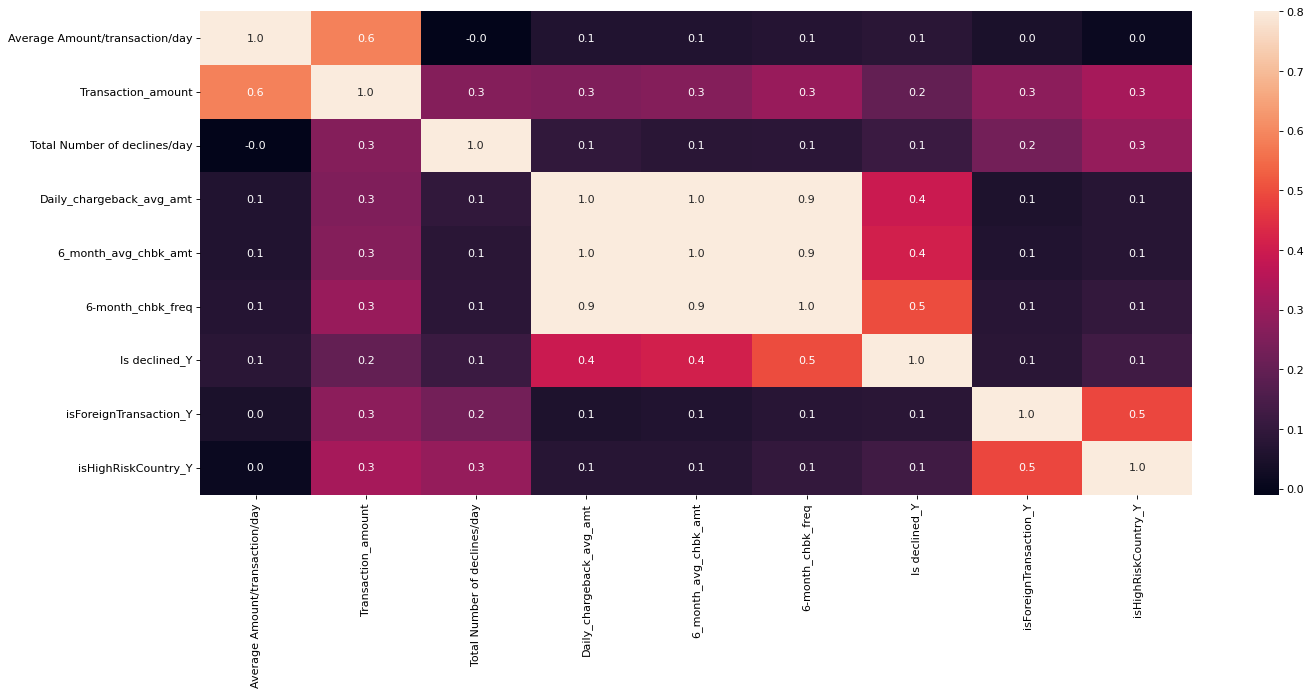

In [12]:
plt.figure(figsize=(20,8),dpi=80)
corrmat = df.corr()
sns.heatmap(corrmat, vmax=.8, fmt='.1f', annot=True)

De esta forma, en este momento se hará la siguiente predicción:
    
- Existen al menos dos grupos de datos: Datos más relevantes para la clasificación y datos menos relevantes para la clasificación.
- Las columnas `isForeignTransaction_Y`, `isHighRiskCountry_Y`, `Transaction_amount` y `Total Number of declines/day` parecen formar uno de esos grupos.
- Las columnas `Daily_chargeback_avg_amt`, `6_month_avg_chbk_amt`, `6-month_chbk_freq` y `Is declined_Y` forman el segundo grupo.
- No hay evidencia para la columna `Average Amount/transaction/day`.

Está predicción solo se convertiría en una hipótesis si fuera confirmada con una matriz de distancias. En este análisis se procederá directamente a implementar un método de clutering.

## Clustering jerárquico

Categoriza las entradas en grupos. Es un método no supervisado, por lo tanto no se usarán datos de entrenamiento, sino que todos los datos serán utilizados para crear una clasificación.

In [13]:
# method=single, complete, average, weighted, centroid, median, ward
Z = linkage(df, "centroid")

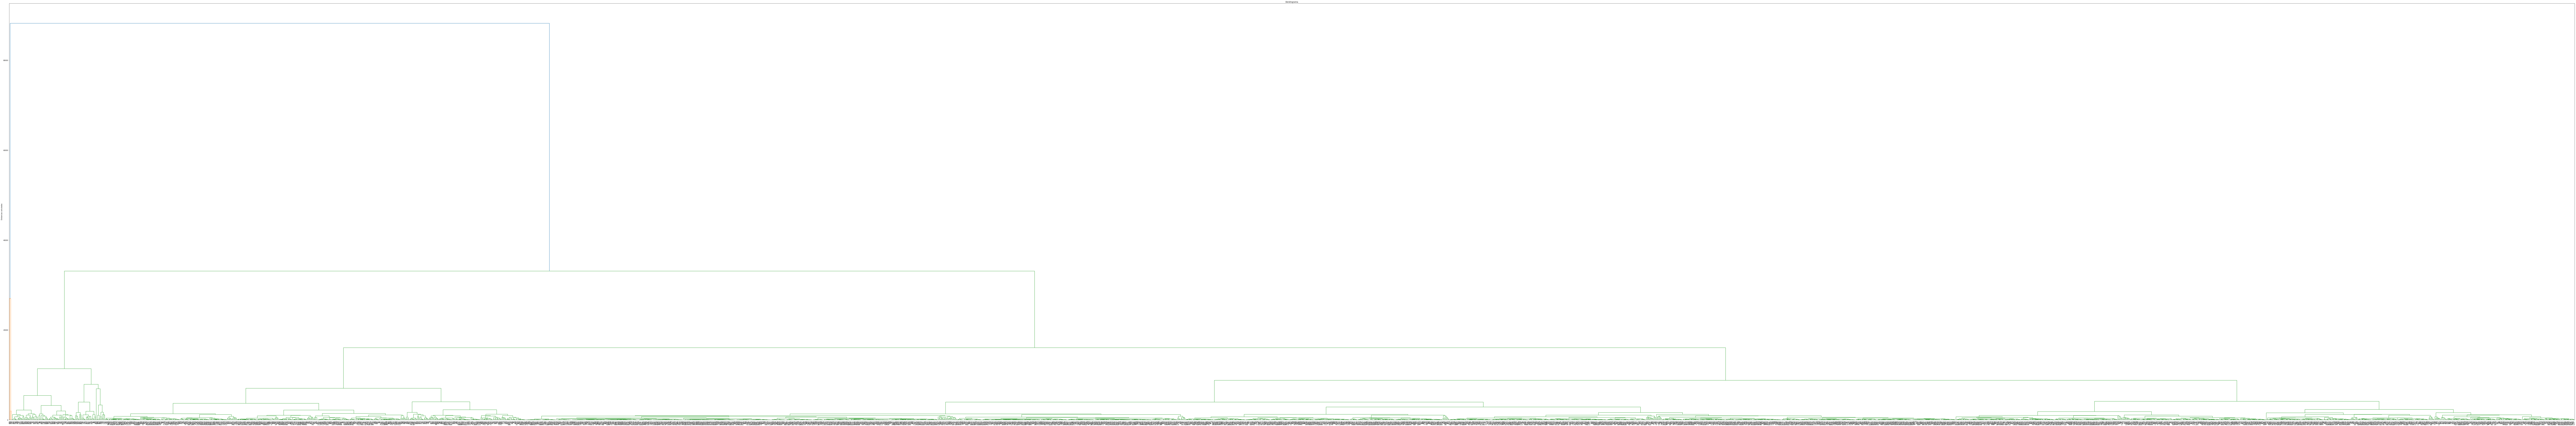

In [14]:
plt.figure(figsize=(300,50))
plt.title("Dendrograma")
plt.ylabel("Distancias calculadas")
dendrogram(Z, leaf_rotation=90.,leaf_font_size=10)
plt.savefig('im/dendrogram.png', format='png', bbox_inches='tight')

In [15]:
coeficiente, distancia = cophenet(Z, pdist(df))

In [16]:
coeficiente

0.8915315812910991

In [17]:
Z[:20]

array([[4.53000000e+02, 4.54000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.02000000e+03, 2.21900000e+03, 6.12306161e-02, 2.00000000e+00],
       [1.35100000e+03, 2.55700000e+03, 7.99292845e-02, 2.00000000e+00],
       [7.80000000e+02, 2.74700000e+03, 1.31015463e-01, 2.00000000e+00],
       [5.67000000e+02, 2.53500000e+03, 2.26191689e-01, 2.00000000e+00],
       [1.31500000e+03, 1.58100000e+03, 2.72923322e-01, 2.00000000e+00],
       [2.38600000e+03, 2.86400000e+03, 3.51360972e-01, 2.00000000e+00],
       [6.82000000e+02, 8.08000000e+02, 3.90558845e-01, 2.00000000e+00],
       [6.73000000e+02, 1.69300000e+03, 4.00283051e-01, 2.00000000e+00],
       [2.19800000e+03, 2.27400000e+03, 4.94398774e-01, 2.00000000e+00],
       [7.48000000e+02, 8.72000000e+02, 5.38279653e-01, 2.00000000e+00],
       [1.35500000e+03, 1.99500000e+03, 5.72548700e-01, 2.00000000e+00],
       [7.24000000e+02, 1.74900000e+03, 6.34476117e-01, 2.00000000e+00],
       [9.16000000e+02, 2.58700000e+03, 6.39055400e